# Complex networks: theory and applications
## Assignment 3: G(n,p) graph

#### Andrea Senacheribbe

---

In [1]:
figpath="figures/"

In [2]:
import numpy as np
import scipy.sparse as sparse, scipy.sparse.csgraph as sgraph, scipy.sparse.linalg as slinalg
import matplotlib.pyplot as plt, matplotlib.cm as cm
import numba as nb
import pandas as pd

In [3]:
# utils for binomial rnd var
@nb.njit
def bin_mean(n,p):
    return n*p

@nb.njit
def bin_std(n,p):
    return np.sqrt(n*p*(1-p))

In [4]:
@nb.njit
def generate_gnp(n, p):
    ia=np.empty(n+1, dtype=np.uint)
    m_max=np.int(bin_mean(n*(n-1)/2, p) + 5*bin_std(n*(n-1)/2, p))+1
    ja=np.empty(m_max, dtype=np.uint)
    
    ia[0]=0
    ia[1]=0
    m=0
    
    for i in range(1, n):
        n_edges=np.random.binomial(i, p)
        
        if n_edges>0:
            ja[m:m+n_edges]=np.random.choice(i, size=n_edges, replace=False)
            m+=n_edges
            
        ia[i+1]=ia[i]+n_edges
        
    assert(m<m_max)
    return m, ia, ja[0:m]

def G(n, p):
    m,ia,ja=generate_gnp(n, p)
    graph=sparse.csr_matrix((np.ones(m,dtype=np.uint8), ja, ia), shape=(n,n), dtype=np.uint8)
    
    return graph+graph.T.tocsr()

## Displaying some statistics about the graph


In [5]:
n=1000
p=0.1
graph=G(n,p)
m=graph.nnz/2

In [6]:
print("n =", n, "(vertices)") 
print("m =", m, "(edges)")

n = 1000 (vertices)
m = 50224.0 (edges)


Plot the **sparsity** of the **adjacency matrix**

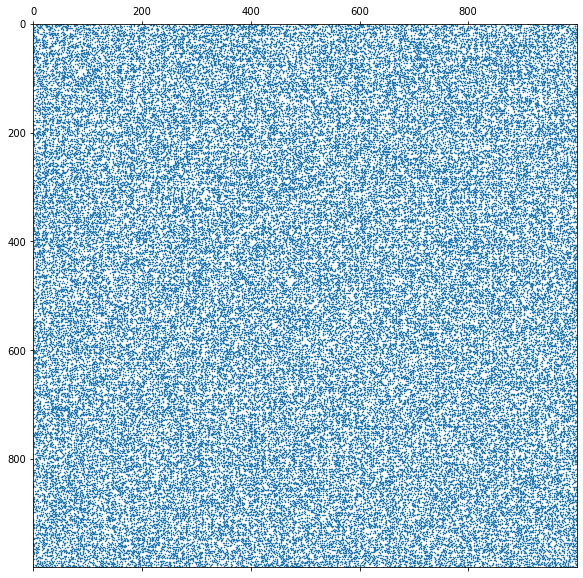

In [7]:
plt.figure(figsize=(10,10))
plt.spy(graph, markersize=.5);
plt.savefig(figpath+"sparsity.png")

## Testing properties

In [8]:
n_s=[100, 1000, 10000, 100000]
c_s=[0.5, 0.9, 1.1, 1.5, 2]

p_l=[str(c)+"/n" for c in c_s]+[str(c)+" log(n)/n" for c in c_s]+["0.01"]
p_f=[lambda n,c=c: c/n for c in c_s]+[lambda n, c=c: (c*np.log(n))/n for c in c_s]+[lambda n: 0.01]
assert(len(p_f)==len(p_l))

In [ ]:
n_gen=100
diameter_test=20

df=pd.DataFrame(columns=["n", "p(n)", "connected", "giant", "diameter", "1st cc", "2nd cc", "degree", "deg_min", "deg_max"])

for n in n_s:
    print("\n-----\nn=", n,"\n-----\n")
    
    
    for p, label in zip(p_f, p_l):
        print(" > p =", label)
        
        degree_min=max(0, np.int(bin_mean(n-1,p(n))-10*bin_std(n-1,p(n)))-1)
        degree_max=min(n-1, np.int(bin_mean(n-1,p(n))+10*bin_std(n-1,p(n)))+5)
        degree=np.zeros(degree_max-degree_min, dtype=np.float)
        connected=0
        gc=0
        lcc_size=0
        lcc2_size=0
        diameter=0
        
        
        for i in range(n_gen): # montecarlo
            graph=G(n,p(n))

            #degree distrib
            #+graph.sum(axis=0).A1
            val, counts=np.unique(graph.sum(axis=1).A1, return_counts=True)
            degree[val-degree_min]+=counts.astype(np.uint)

            #connectivity
            c_cc,cc=sgraph.connected_components(graph)
            if c_cc==1:
                connected+=1
            
            #giant component and lcc size
            val, counts=np.unique(cc, return_counts=True)
  
            lcc_max=np.max(counts)
            gc+=lcc_max>n/10
            lcc_size+=lcc_max
            if c_cc>1:
                lcc2_size+=np.partition(counts, -2)[-2]
                
            #diameter
            if c_cc==1:
                diameter+=np.max(sgraph.shortest_path(graph, indices=np.random.choice(lcc_max, size=min(diameter_test,lcc_max),replace=False), return_predecessors=False))
            else:
                max_cc=val[np.argmax(counts)]
                indices=np.where(cc==max_cc)[0]
                diameter+=np.max(sgraph.shortest_path(graph[indices,:].tocsc()[:, indices], indices=np.random.choice(lcc_max, size=min(diameter_test,lcc_max),replace=False), return_predecessors=False))

        #degree distribution
        nz=degree.nonzero()
        deg_min=np.min(nz)
        deg_max=min(np.max(nz)+1, degree.size)
        degree=degree[deg_min:deg_max]
        assert(np.sum(degree)==n*n_gen)
        degree/=n*n_gen
        
        #lcc2 size
        lcc2_size=lcc2_size/(n_gen-connected) if connected<n_gen else np.NaN
    
        assert(diameter!=np.inf)
        df=df.append({"n": n, "p(n)":label, "connected": connected/n_gen, "giant":gc/n_gen, "diameter":diameter/n_gen, "1st cc":lcc_size/n_gen, "2nd cc":lcc2_size, "degree":degree, "deg_min":deg_min, "deg_max":deg_max},ignore_index=True)
    

print("\n\n-------")

In [ ]:
df

In [ ]:
df.to_pickle("./results.pkl")